# Beta Hedging

_Roshan Mahes (Based on the Quantopian Lecture Series)._

As usual, we first import our libraries:

In [1]:
import math
import numpy as np
import pandas as pd

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression

# plot + styling
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# get pricing data
import yfinance as yf

### Factor Models

Factor models are a way of explaining the returns of one asset via a linear combination of the returns of other assets. The general form of a (factor or linear regression) model is

\begin{align*}
Y = \alpha + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n.
\end{align*}

Note that the $X$'s can also be indicators instead of assets.

An asset's beta to another asset is just the $\beta$ from the above model. For instance, if we regressed TSLA against the S&P 500 ETF SPY using the model $Y_{TSLA} = \alpha + \beta X$, then TSLA's beta exposure to the S&P 500 ETF would be that beta. If we used the model $Y_{TSLA} = \alpha + \beta X_{SPY} + \beta X_{AAPL}$, then we now have two betas, one is TSLA's exposure to the S&P 500 ETF and one is TSLA's exposure to AAPL. In the following, $\beta$ will refer to a stock's beta exposure to the S&P 500 ETF unless otherwise specified.

Let's download the pricing data of the AAPL stock and the SPY ETF:

In [2]:
# load Apple data (daily)
ticker = yf.Ticker('AAPL')
df_AAPL = ticker.history(period='max')
df_AAPL.to_csv('data/AAPL.csv')

# load SPY data (daily)
ticker = yf.Ticker('SPY')
df_SPY = ticker.history(period='max')
df_SPY.to_csv('data/SPY.csv')

Our data consists of the following:

In [3]:
print('Apple data (AAPL):\n', df_AAPL, '\n\n')
print('S&P 500 ETF data (SPY):\n', df_SPY)

Apple data (AAPL):
               Open    High     Low   Close     Volume  Dividends  Stock Splits
Date                                                                          
1980-12-12    0.10    0.10    0.10    0.10  469033600        0.0           0.0
1980-12-15    0.10    0.10    0.10    0.10  175884800        0.0           0.0
1980-12-16    0.09    0.09    0.09    0.09  105728000        0.0           0.0
1980-12-17    0.09    0.09    0.09    0.09   86441600        0.0           0.0
1980-12-18    0.09    0.09    0.09    0.09   73449600        0.0           0.0
...            ...     ...     ...     ...        ...        ...           ...
2020-08-31  127.58  131.00  126.00  129.04  225702700        0.0           4.0
2020-09-01  132.76  134.80  130.53  134.18  152470100        0.0           0.0
2020-09-02  137.59  137.98  127.00  131.40  200119000        0.0           0.0
2020-09-03  126.91  128.84  120.50  120.88  254723200        0.0           0.0
2020-09-04  120.07  123.70  111.

Notice Apple's stock split on 2020-08-31. We plot the daily returns of the year 2019:

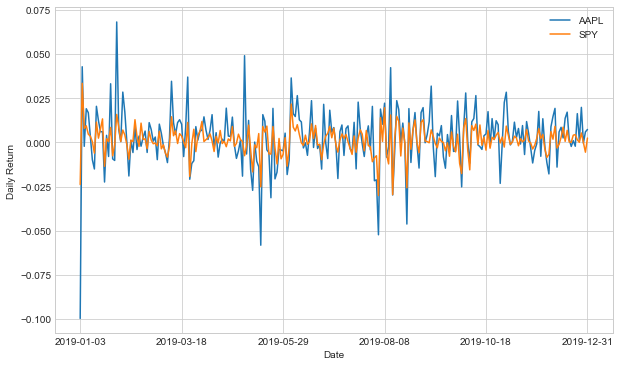

In [4]:
start = '2019-01-01'
end = '2019-12-31'

df_AAPL = pd.read_csv('data/AAPL.csv', index_col=0)
asset = df_AAPL.loc[start:end, 'Close']

df_SP500 = pd.read_csv('data/SPY.csv', index_col=0)
benchmark = df_SP500.loc[start:end, 'Close']

# take the percent changes to get to returns
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]

r_a.plot(label='AAPL')
r_b.plot(label='SPY')
plt.ylabel("Daily Return")
plt.legend();

It seems that Apple's stock can be predicted quite well by the SPY ETF. To check this, we perform the refression to find $\alpha$ and $\beta$:

In [5]:
X = r_b.values
Y = r_a.values

def linreg(x,y):
    x = sm.add_constant(x) # add a column of 1s to our data (for intercept)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1] # remove the constant
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
historical_beta = beta # we will use this later

print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 0.0009488846630787345
beta: 1.550921047269592


If we plot the line $\alpha + \beta X$, we can see that it does indeed look like the line of best fit:

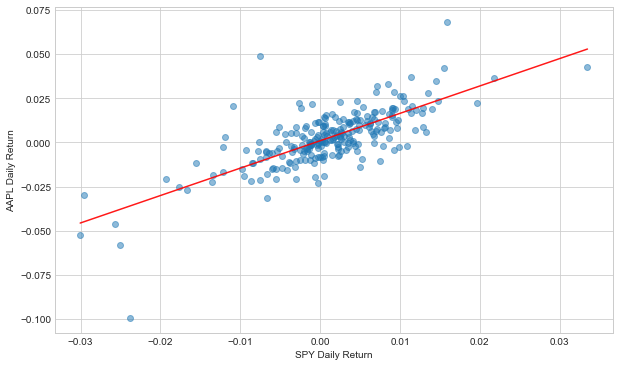

In [6]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.5) # plot returns
plt.xlabel("SPY Daily Return")
plt.ylabel("AAPL Daily Return")

# add regression line (red)
plt.plot(X2, Y_hat, 'r', alpha=0.9);

### Risk Exposure

More generally, this beta gets at the concept of how much risk exposure you take on by holding an asset. If an asset has a high beta exposure to the S&P 500 ETF, then while it will do very well while the market is rising, it will do very poorly when the market falls (e.g. during the Covid period). A high beta corresponds to high speculative risk. You are taking out a more volatile bet.

Stratgies that have negligible beta exposure to as many factors as possible are valuable. What this means is that all of the returns in a strategy lie in the $\alpha$ portion of the model, and are independent of other factors. This is highly desirable, as it means that the strategy is agnostic to market conditions. It will make money equally well in a crash as it will during a bull market. These strategies are the most attractive to individuals with huge cash pools.

### Hedging

The process of reducing exposure to other factors is known as _risk management_. Hedging is one of the best ways to perform risk management in practice. If we determine that our portfolio's returns are dependent on the market via the relation

\begin{align*}
Y_{portfolio} = \alpha + \beta X_{SPY},
\end{align*}

then we can take out a short position in SPY to try to cancel out this risk. The amount we take out is $-\beta V$ where $V$ is the total value of our portfolio. This works because if our returns are approximated by $\alpha + \beta X_{SPY}$, then adding a short in SPY will make our new returns be $\alpha + \beta X_{SPY} - \beta X_{SPY} = \alpha$. Our returns are now purely alpha, which is independent of SPY and will suffer no risk exposure to the market. When a strategy exhibits a consistent beta of $0$, we say that this strategy is _market neutral_.

The only problem here is that the beta we estimated is not necessarily going to stay the same as we walk forward in time. As such the amount of short we took out in the SPY may not perfectly hedge our portfolio, and in practice it is quite difficult to reduce beta by a significant amount. Each estimate has a stardard error that corresponds with how stable the estimate is within the observed data.

Now that we know how much to hedge, let's see how it affects our returns. We will build our portfolio using the asset and the benchmark, weighing the benchmark by $-\beta$ (negative since we are short in it).

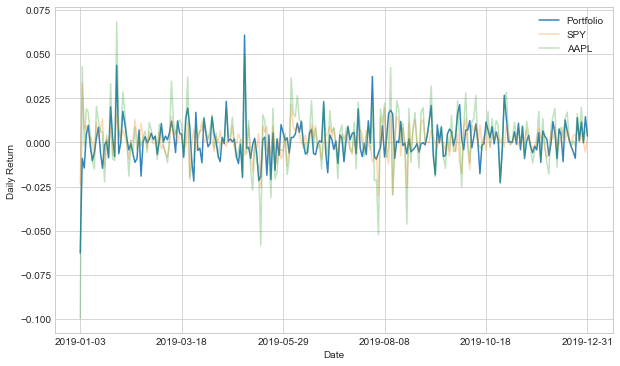

In [7]:
# construct portfolio with beta hedging
portfolio = r_a - beta * r_b 
portfolio.name = "Portfolio"

# plot portfolio returns and assets
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.3, label='SPY')
r_a.plot(alpha=0.3, label='AAPL')
plt.ylabel("Daily Return")
plt.legend();

It looks like the portfolio return follows the asset alone fairly closely. We can quantify the difference in their performances by computing the mean returns and the volatilities (standard deviations of returns) for both:

In [8]:
print(f'The portfolio return changed from {r_a.mean():.4f} to {portfolio.mean():.4f}.')
print(f'The volatility changed from {r_a.std():.4f} to {portfolio.std():.4f}.')

The portfolio return changed from 0.0027 to 0.0009.
The volatility changed from 0.0165 to 0.0111.


We've decreased volatility at the expense of some returns. Let's check that the $\alpha$ is the same as before, while the $\beta$ has been eliminated:

In [9]:
P = portfolio.values
alpha, beta = linreg(X,P)
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

alpha: 0.0009488846630787341
beta: 3.616898447411643e-16


Note that we developed our hedging strategy using historical data. We can check that it is still valid out of sample by checking the alpha and beta values of the asset and the hedged portfolio in a different time frame, namely this year:

Asset Out of Sample Estimate:
alpha: 0.002263998258490222
beta: 1.1293847269106256

Portfolio Out of Sample:
alpha: 0.0022639982584902216
beta: -0.42153632035896654


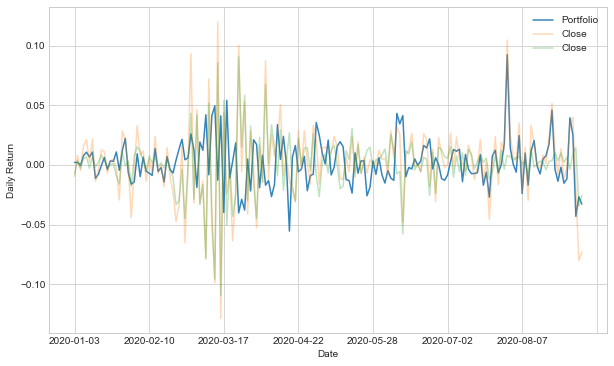

In [10]:
# Get data for a different time frame:
start = '2020-01-01'
end = '2020-12-31'

asset = df_AAPL.loc[start:end, 'Close']
benchmark = df_SP500.loc[start:end, 'Close']

# compute alpha and beta for the asset
r_a = asset.pct_change()[1:]
r_b = benchmark.pct_change()[1:]
X = r_b.values
Y = r_a.values
alpha, beta = linreg(X,Y)
print('Asset Out of Sample Estimate:')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

# create hedged portfolio and compute alpha and beta
portfolio = r_a - historical_beta * r_b
P = portfolio.values
alpha, beta = linreg(X,P)
print('\nPortfolio Out of Sample:')
print('alpha: ' + str(alpha))
print('beta: ' + str(beta))

# plot portfolio returns and assets
portfolio.name = "Portfolio"
portfolio.plot(alpha=0.9)
r_a.plot(alpha=0.3);
r_b.plot(alpha=0.3)
plt.ylabel("Daily Return")
plt.legend();

As we can see, the beta estimate changes a good deal when we look at the out of sample estimate. The beta that we computed over our historical data doesn't do a great job at reducing the beta of our portfolio, but does manage to reduce the magnitude by about 1/2.

Hedging against a benchmark such as the market will indeed reduce your returns while the market is not doing poorly. This is, however, completely fine. If your algorithm is less volatile, you will be able to take out leverage on your strategy and multiply your returns back up to their original amount. Even better, your returns will be far more stable than the original volatile beta exposed strategy.

By and large, even though high-beta strategies tend to be deceptively attractive due to their extremely good returns during periods of market growth, they fail in the long term as they will suffer extreme losses during a downturn. There are strategies for hedging that may be better suited for other investment approaches.

#### Pairs Trading

One is pairs trading, in which a second asset is used in place of the benchmark here. This would allow you, for instance, to cancel out the volatility in an industry by being long in the stock of one company and short in the stock of another company in the same industry.

#### Long Short Equity

In this case we define a ranking over a group of $n$ equities, then long the top $p\%$ and short the bottom $p\%$ in equal dollar volume. This has the advantage of being implicitly, versus explicitly, hedged when $n$ is large. To see why this is the case, imagine buying a set of 100 securities randomly. The chance that the market exposure beta of these 100 is far from 1.0 is very low, as we have taken a large sample of the market. Similarly, when we rank by some independent metric and buy the top 100, the chance that we select securities whose overall beta is far from 1.0 is low. So in selecting 100 long and 100 short, the strategy beta should be very close to 1 - 1 = 0. Obviously some ranking systems will introduce a sample bias and break this assumption, for example ranking by the estimated beta of the equity.

Another advantage of long short equity strategies is that you are making a bet on the ranking, or in other words the differential in performance between the top and bottom ranked equities. This means that you don't have to even worry about the alpha/beta tradeoff encountered in hedging.

_This document is based on the Quantiopian Lecture written by Evgenia Nitishinskaya, Delaney Granizo-Mackenzie and David Edwards._